# Mixture Models - The comeback!

Installo il necessario per lavorare su Stan:

In [19]:
!pip install pystan
!pip install fbprophet
!apt-get install -y build-essential
!apt-get install -y libboost-all-dev
!pip install cmdstanpy
import os
os.environ['CMDSTAN'] = '/content/cmdstan-2.28.0'
!wget https://github.com/stan-dev/cmdstan/releases/download/v2.28.0/cmdstan-2.28.0.tar.gz
!tar -xf cmdstan-2.28.0.tar.gz

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
ERROR: Could not build wheels for fbprophet, which is required to install pyproject.toml-based projects
Reading package lists... Done
Building dependency tree... Done
Reading state infor

In [20]:
import cmdstanpy
cmdstanpy.install_cmdstan(overwrite=True)


CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.33.1
Download successful, file: /tmp/tmprxtt2z5i
Extracting distribution


DEBUG:cmdstanpy:cmd: make clean-all
cwd: None


Unpacked download as cmdstan-2.33.1
Building version cmdstan-2.33.1, may take several minutes, depending on your system.
Overwrite requested, remove existing build of version cmdstan-2.33.1


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Rebuilding version cmdstan-2.33.1


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.33.1
Test model compilation


True

In [21]:
!pip install --upgrade arviz
!pip install --upgrade cmdstanpy


In [22]:
# Import modules
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions


# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

$\newcommand{\iid}{\stackrel{\tiny\mbox{iid}}{\sim}}$
$\newcommand{\ind}{\stackrel{\tiny\mbox{ind}}{\sim}}$
In mixture model, we account for heterogeneity in the data by assuming that there is not "one single" data generating process, but actually $H$ of them.

Therefore, we expect to find $H$ different subpopulations (== clusters) in our data, and that each subpopulation is homogeneous: it is suitably modeled by a density, typically from a parametric family.

In its most general form, let $f_1(\cdot), \dots, f_H(\cdot)$ be $H$ probability density functions over a space $\mathbb{Y}, \mathcal{Y}$, $\mathbf{w} = (w_1, \ldots, w_H)$ a vector in the $H$-simplex; a mixture model assumes the following likelihood

\begin{equation}
    y_1, \ldots, y_n \mid \mathbf{w}, \{f_h\}_{h=1}^H \iid f^*(y) := \sum_{h=1}^H w_h f_h(y)
    \tag{1}
\end{equation}

We refer to the $f_h$'s as the _components_ of the mixture

The connection to clustering is made more explicit by introducing "cluster assignment" variables $c_i$, $i=1, \ldots, n$ such that
$$
    \mathbb{P}(c_i = h \mid \mathbf{w}) = w_h
$$

Then, the mixture likelihood can be restated as the following hierarchical model

\begin{align*}
    y_i \mid c_i = h, \{f_h\}_{h=1}^H &\ind f_h \\
    \mathbb{P}(c_i = h \mid \mathbf{w}) &= w_h
    \tag{2}
\end{align*}

Usually, $\{f_j\}_{j=1}^K$ belong to the same parametric family (e.g., the normal distribution), and differ only for the specific values of the parameters (e.g., every component has a different mean/variance). But this might not always be the case.

## Gaussian Mixture Model
We consider a fictional dataset coming from the following distribution:
$$
    y_1, \dots, y_n \iid \frac{1}{2}\mathcal{N}(-3.0, 1.0) + \frac{1}{2}\mathcal{N}(3.0,1.0)
$$

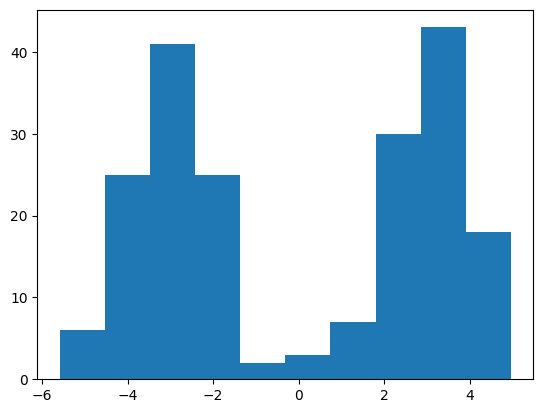

In [23]:
data = np.concatenate([np.random.normal(loc=3, scale=1, size=100),
                       np.random.normal(loc=-3, scale=1, size=100)])
plt.hist(data)
plt.show()

And we assume the following Finite Mixture model for our data:

\begin{align*}
    y_1, \ldots, y_n \mid \mathbf{w}, \boldsymbol{\mu}, \boldsymbol{\sigma}^2 &\iid \sum_{h=1}^{H} w_h \mathcal{N}(\mu_h, \sigma^2_h) \\
    \mathbf{w} &\sim \operatorname{Dirichlet}(\boldsymbol{\alpha}) \\
    (\mu_h, \sigma_h) &\iid \mathcal{N}(\mu_0, \sigma^2_0) \times \mathcal{HC}(0, \sigma_{max}), \qquad h=1,\dots,H
\end{align*}

**How do we implement this model in `stan`?**

1. *From [Stan Users' Guide (Section 7)][1]:*
> **Stan does not support sampling discrete parameters**. So it is not possible to directly translate BUGS or JAGS models with discrete parameters (i.e., discrete stochastic nodes). Nevertheless, it is possible to code many models that involve bounded discrete parameters by marginalizing out the discrete parameters.

This means that we can not use the model formulation with latent cluster allocation. We need to marginalize those $c_i$, so that we avoid the use of discrete parameters. But we already know which is the likelihood once the latent cluster allocation variables have been marginalized, don't we?

Ok, but we have a problem: such distribution is not implemented in stan!

2. *From [Stan Reference Manual (Section 7.3)][2]*
> The basis of Stan’s execution is the evaluation of a log probability function (specifically, a probability density function) for a given set of (real-valued) parameters; this function returns the log density of the posterior up to an additive constant. Data and transformed data are fixed before the log density is evaluated. The total log probability is initialized to zero. Next, any log Jacobian adjustments accrued by the variable constraints are added to the log density (the Jacobian adjustment may be skipped for optimization). Sampling and log probability increment statements may add to the log density in the model block. A log probability increment statement directly increments the log density with the value of an expression

This means that we actually have a way to implement a mixture model in `stan`! Let's see how can we do that.

<!--- References --->
[1]: https://mc-stan.org/docs/stan-users-guide/latent-discrete.html
[2]: https://mc-stan.org/docs/reference-manual/increment-log-prob.html

NON CONSIDERARE IL BLOCCO SOTTOSTANTE:

In [14]:

gaussian_mix_uni = """ data {
    int<lower=0> N;  // Number of observations
    vector[N] y;     // Observations
    int<lower=1> K;   // Number of classes
}

parameters {
    vector[K] mu;           // Mean parameter for each class
    vector<lower=0>[K] sigma;  // Standard deviation for each class
    simplex[K] w;           // Mixture weights
}

model {
    // Weakly informative priors
    mu ~ normal(0, 10);
    sigma ~ cauchy(0, 5);
    w ~ dirichlet(rep_vector(1, K));

    for (n in 1:N) {
        vector[K] lp;  // Log probabilities for each class
        for (k in 1:K) {
            lp[k] = log(w[k]) + normal_lpdf(y[n] | mu[k], sigma[k]);
        }
        target += log_sum_exp(lp);  // Log-sum-exp trick for numerical stability
    }
}

generated quantities {
    vector[N] y_pred;  // Simulated observations

    for (n in 1:N) {
        int k = categorical_rng(w);  // Sample a class based on the mixture weights
        y_pred[n] = normal_rng(mu[k], sigma[k]);  // Simulate an observation
    }
}
"""

# Write stan model to file
stan_file = "./stan/gaussian_mix_uni.stan"
with open(stan_file, "w") as f:
    print(gaussian_mix_uni, file=f)

# Compile stan model
gaussian_mix_uni = CmdStanModel(stan_file=stan_file)


DEBUG:cmdstanpy:Removing /content/stan/gaussian_mix_uni
11:52:08 - cmdstanpy - INFO - compiling stan file /content/stan/gaussian_mix_uni.stan to exe file /content/stan/gaussian_mix_uni
INFO:cmdstanpy:compiling stan file /content/stan/gaussian_mix_uni.stan to exe file /content/stan/gaussian_mix_uni
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=gaussian_mix_uni.stan /content/stan/gaussian_mix_uni
cwd: /root/.cmdstan/cmdstan-2.33.1


KeyboardInterrupt: ignored

CONSIDERA QUESTO: qui facciamo il sampling delle medie conoscendo il gruppo di appartenenza

In [24]:
gaussian_mix_uni = """
data {
  int N;
  int H;
  array[N] real y;

  real<lower=0> alpha;
  array[2] real p0_params;
}

transformed data {
  real mu0 = p0_params[1];
  real sigma0 = p0_params[2];
 }

parameters {
  array[H] real means;
  array[H] real <lower=0> std_devs;
  simplex[H] weights; # sono le probabilità di assegnamento
 }

model {
   //Likelihood
   vector[H] contributions;
   for (i in 1:N){
     for (h in 1:H){
      contributions[h] = log(weights[h]) + normal_lpdf(y[i] | means[h], std_devs[h]);
      }
      target += log_sum_exp(contributions);
    }


   // Prior
   target += dirichlet_lpdf(weights | rep_vector(alpha,H)); # non siamo convinti della target distribution
   means ~ normal(mu0, sigma0);
   std_devs ~ uniform(0, 10);

}
"""

# Write stan model to file
stan_file = "./stan/gaussian_mix_uni.stan"
with open(stan_file, "w") as f:
    print(gaussian_mix_uni, file=f)

# Compile stan model
gaussian_mix_uni = CmdStanModel(stan_file=stan_file)

12:02:33 - cmdstanpy - INFO - compiling stan file /content/stan/gaussian_mix_uni.stan to exe file /content/stan/gaussian_mix_uni
INFO:cmdstanpy:compiling stan file /content/stan/gaussian_mix_uni.stan to exe file /content/stan/gaussian_mix_uni
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=gaussian_mix_uni.stan /content/stan/gaussian_mix_uni
cwd: /root/.cmdstan/cmdstan-2.33.1
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=gaussian_mix_uni.stan --o=/content/stan/gaussian_mix_uni.hpp /content/stan/gaussian_mix_uni.stan
Error in 'gaussian_mix_uni.stan', line 34, column 61: Comments beginning with
    # were removed in Stan 2.33.0. Use // to begin line comments; this can be
    done automatically using the auto-format flag to stanc
Error in 'gaussian_mix_uni.stan', line 19, column 23: Comments beginning with
    # were removed in Stan 2.33.0. Use // to begin line comments; this can be
    done automatically using the auto-for

ValueError: ignored

In [ ]:
# Input data
gmm_data = {
    "N": len(data),
    "H": 4,
    "y": data,
    "alpha": 1.0,
    "p0_params": np.array([0, 5])
}

# Algorithm parameters
algo_params = {
    "n_chains": 4,
    "n_burnin": 1000,
    "n_iter": 1000
}

# Sample
gmm_fit = gaussian_mix_uni.sample(data=gmm_data, chains=algo_params["n_chains"], parallel_chains=algo_params["n_chains"],
                                  iter_warmup=algo_params["n_burnin"], iter_sampling=algo_params["n_iter"])

# Convert to arviz data type
chains = az.from_cmdstanpy(gmm_fit)

DEBUG:cmdstanpy:cmd: /content/stan/gaussian_mix_uni info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjrezwiu1/3ike0sbf.json
11:06:44 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/gaussian_mix_uni', 'id=1', 'random', 'seed=98232', 'data', 'file=/tmp/tmpjrezwiu1/3ike0sbf.json', 'output', 'file=/tmp/tmpjrezwiu1/gaussian_mix_uniuz65gpbf/gaussian_mix_uni-20231111110644_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/gaussian_mix_uni', 'id=3', 'random', 'seed=98232', 'data', 'file=/tmp/tmpjrezwiu1/3ike0sbf.json', 'output', 'file=/tmp/tmpjrezwiu1/gaussian_mix_uniuz65gpbf/gaussian_mix_uni-20231111110644_3.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/gaussian_mix_uni', 'id=4', 'random', 'seed=98232', 'data', 'file=/tmp/

11:07:55 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/gaussian_mix_uni', 'id=1', 'random', 'seed=98232', 'data', 'file=/tmp/tmpjrezwiu1/3ike0sbf.json', 'output', 'file=/tmp/tmpjrezwiu1/gaussian_mix_uniuz65gpbf/gaussian_mix_uni-20231111110644_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpjrezwiu1/gaussian_mix_uniuz65gpbf/gaussian_mix_uni-20231111110644_1.csv
 console_msgs (if any):
	/tmp/tmpjrezwiu1/gaussian_mix_uniuz65gpbf/gaussian_mix_uni-20231111110644_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
 

AttributeError: ignored

In [ ]:
az.plot_trace(chains, var_names=["means", "std_devs"], compact=False)
plt.tight_layout()
plt.show()

Looking at the chains of the cluster specific parameters is misleading, and we know why! What may happen is that either the posterior distribution of those parameters is multi-modal (thus meaning taht the model is not identifiable) or there is no agreement between parallel chains.

**Take Home Message**: you can assess convergence of the MCMC for a mixture model only looking at the common parameters, i.e., those that do not depend on $H$!

### Posterior Predictive Distribution

The type of checks that make sense with mixture models are predictive checks. Hence, we can compute the posterior predictive density and compare it with the empirical density histogram of the data.

Given a new value $y^*$, we need to compute:

\begin{align*}
    \mathcal{L}(y^* \mid \mathbf{y}) &= \int \mathcal{L}(y^* \mid \mathbf{w}, \boldsymbol{\mu}, \boldsymbol{\sigma}^2) \, \pi(\mathbf{w} \mid \mathbf{y}) \, \pi(\boldsymbol{\mu} \mid \mathbf{y}) \, \pi(\boldsymbol{\sigma}^2 \mid \mathbf{y}) \, \mathrm{d}\mathbf{w} \,\mathrm{d}\boldsymbol{\mu} \, \mathrm{d}\boldsymbol{\sigma}^2, \\
    &\approx \frac{1}{M} \sum_{j = 1}^{M}\sum_{h = 1}^{H} w_{h}^{(j)}\mathcal{N}\left(y^* \mid \mu_h^{(j)}, \sigma_h^{2(j)}\right),
\end{align*}

where $\{\mathbf{w}^{(j)}\}_{j=1}^{M}$, $\{\boldsymbol{\mu}^{(j)}\}_{j=1}^{M}$ and $\{\boldsymbol{\sigma}^{2(j)}\}_{j=1}^{M}$ are the corresponding MCMC chains we retrieve from `stan`. This holds for a single value $y^* \in \mathbb{R}$. In order to retrieve a density, we can compute the same quantity over a grid of points.

In [ ]:
# Function that computes the predictive distribution for a Gaussian Mixture Model (1D)
def predictive_gaussian_mix_uni(chains, x_grid):
    # Extract chains
    weights = np.vstack(chains.posterior.weights)
    means = np.vstack(chains.posterior.means)
    std_devs = np.vstack(chains.posterior.std_devs)
    num_components = weights.shape[1]
    # Create buffer and fill
    out = np.zeros(shape=(weights.shape[0], len(x_grid)))
    for i in range(out.shape[0]):
        eval_dens = np.zeros_like(x)
        for h in range(num_components):
            eval_dens += weights[i,h] * tfd.Normal(means[i,h], std_devs[i,h]).prob(x)
        out[i,:] = eval_dens
    # Copmute mean
    return np.mean(out, axis=0)

In [ ]:
# Define grid of points
x = np.linspace(-8, 8, 1000)

# Compute posterior mean density
post_dens = predictive_gaussian_mix_uni(chains, x)

In [ ]:
# Plot posterior mean density
plt.hist(data, density=True, alpha = 0.5)
plt.plot(x, post_dens, linewidth=3)
plt.show()

### What about clustering?

We already know that Mixture Models are aminly used for clustering. Clustering is obtained via the latent cluster allocation variables $\{c_i\}_{i=1}^{N}$ that are naturally introduced if we need to implement a Gibbs Sampler.

We can use a trick to retrieve the latent cluster allocation *after* the sampling. We can do it in `stan`, in the `generated quantities` block, or in Python. What e need to do is to sample from its full conditional distribution for every state of the chain, like we would do in a Gibbs sampler. Hence:

\begin{align*}
    c_i = h \mid rest &\propto \mathcal{L}(y_i \mid c_i = h, \mathbf{w}, \boldsymbol{\mu}, \boldsymbol{\sigma}^2)\mathbb{P}(c_i = h \mid \mathbf{w}), \\
    &= w_h \, \mathcal{N}(y_i \mid \mu_h, \sigma^2_h),
\end{align*}
for $i = 1, \dots, N$ and for $h = 1, \dots, H$.

QUI ABBAIMO PROVATO A FARE QUALCHE MODIFICA NOI:

In [ ]:
gaussian_mix_uni_clus = """
data {
  int N;
  int H;
  array[N] real y;
  array[2] real p0_params;
  }

transformed data {
  real mu0 = p0_params[1];
  real sigma0 = p0_params[2];
}

parameters {
  array[H] real means;
  array[H] real <lower=0> std_devs;
  simplex[H] weights;
  }

model {
  //Likelihood
   vector[H] contributions;
   for (i in 1:N){
     for (h in 1:H){
      contributions[h] = log(weights[h]) + normal_lpdf(y[i] | means[h], std_devs[h]);
      }
      target += log_sum_exp(contributions);
    }

    // Prior
   weights ~ categorical(H);
   means ~ normal(0, sigma0);
   sigma ~ uniform(0, 10);
}

generated quantities {

  int<lower=1, upper=H> c_pred[N];

  for (i in 1:N) {
    vector[H] log_posterior;

    // Compute the log posterior for each cluster
    for (h in 1:H) {
      log_posterior[h] = log(weights[h]) + normal_lpdf(y[i] | mu[h], sigma[h]);
    }

    // Normalize the log posterior to obtain probabilities
    vector[H] posterior = exp(log_posterior - log_sum_exp(log_posterior));

    // Sample from the full conditional distribution
    c_pred[i] = categorical_rng(posterior);
  }

"""

# Write stan model to file
stan_file = "./stan/gaussian_mix_uni_clus.stan"
with open(stan_file, "w") as f:
    print(gaussian_mix_uni_clus, file=f)

# Compile stan model
gaussian_mix_uni_clus = CmdStanModel(stan_file=stan_file)

ValueError: ignored

In [ ]:
# Input data
gmm_data = {
    "N": len(data),
    "H": 4,
    "y": data,
    "alpha": 0.5,
    "p0_params": np.array([0, 5, 5])
}

# Algorithm parameters
algo_params = {
    "n_chains": 4,
    "n_burnin": 1000,
    "n_iter": 1000
}

# Sample
gmm_clus_fit = gaussian_mix_uni_clus.sample(data=gmm_data, chains=algo_params["n_chains"], parallel_chains=algo_params["n_chains"],
                                            iter_warmup=algo_params["n_burnin"], iter_sampling=algo_params["n_iter"])

# Convert to arviz data type
chains = az.from_cmdstanpy(gmm_clus_fit)

### Point estimates with Mixture Models
We know that mixture models are non-identifiable, as we can see from the MCMC chains we retrieve from `stan`. There are several ways to solve this non-identifiability issue and retrieve point estimates for the clustering and for the cluster-specific parameters. What is done, usually, is to find a point estimate for the cluster and then retrieve the cluster-specific variables once the cluster is known.

To find a point estimate for the cluster, we will follow a decision-theoretic approach. The idea is to use a loss function and find the partition that minimizes such loss function. One of the most known loss function for clustering is the Binder's loss, defined as:
$$
    \sum_{i=1}^n \sum_{j=1}^n (\mathbb I [c_i = c_j] - p_{ij})^2
$$
where $p_{ij}$ is the posterior probability that observations $i$ and $j$ belong to the same cluster, i.e., $\mathbb{P}(c_i = c_j \mid \mathbf{y})$.

In [ ]:
# Function that computes the posterior similarity matrix
def get_psm(clus_alloc_chain):
    c_chain = np.vstack(clus_alloc_chain)
    out = np.zeros((c_chain.shape[1], c_chain.shape[1]))
    for i in range(c_chain.shape[1]):
        for j in range(i):
            out[i, j] = np.mean(c_chain[:, i] == c_chain[:, j])
    return out + out.T + np.eye(out.shape[0])

In [ ]:
# Function that computes the cluster estimate that minimizes the binder loss function
def minbinder_sample(clus_alloc_chain, psm):
    losses = np.zeros(len(clus_alloc_chain))
    c_chain = np.vstack(clus_alloc_chain)
    for i in range(c_chain.shape[1]):
        for j in range(i):
            losses += 2 * (np.mean(c_chain[:, i] == c_chain[:, j]) - psm[i, j])
    best_iter = np.argmin(losses)
    return clus_alloc_chain[best_iter]

In [ ]:
# Retrieve cluster allocation variables
clust_allocs_chain = np.vstack(chains.posterior.cluster_allocs)

In [ ]:
# Compute posterior similarity matrix
psm = get_psm(clust_allocs_chain)

In [ ]:
# Compute point estimate of the cluster
best_clus = minbinder_sample(clust_allocs_chain, psm)

In [ ]:
# Plot the point cluster estimate on the empirical density histogram
plt.hist(data, density=True, alpha=0.3)
for h in np.unique(best_clus):
    currd = data[best_clus == h]
    plt.scatter(currd, np.zeros_like(currd) + 0.005 * (h+1))

Then, given the point estimate of the clustering $\mathbf{c}^*$, we can estimate the parameters in each cluster. Let $c^*_h$ denote the index-set of the $h$--th cluster (e.g., $c^*_1 = \{1, 3, 10\}$, $c^*_2 = \{0, 2, 4, 5, 6\}$ ...)
Then, for every cluster-specific parameter $\theta_h$, we can estimate it as:
$$
    \hat \theta_h = \frac{1}{M} \sum_{j=1}^M \frac{1}{\# c^*_h} \sum_{i \in c^*_h} \theta^{(j)}_{c_{i}^{(j)}}
$$
where $\mu^{(j)}_\ell$ is the mean of the $\ell$--th cluster at the $j$--th MCMC iteration. Similarly for the variance $\hat \sigma_h^2$.

In [ ]:
# Function that computes the cluster-specific estimates given the best cluster estimate
def unique_vals_given_clus(chains, best_clus):
    c_allocs = np.vstack(chains.posterior.cluster_allocs).astype(int)
    means = np.vstack(chains.posterior.means)
    std_devs = np.vstack(chains.posterior.std_devs)
    out = []
    for h in np.unique(best_clus):
        # Find indexes of data in cluster h and corresponding cluster allocations
        data_idx = np.where(best_clus == h)[0]
        uniq_vals_idx = c_allocs[:, data_idx]
        # Prepare and fill buffers
        means_by_iter = np.empty((c_allocs.shape[0], len(data_idx)))
        std_devs_by_iter = np.empty_like(means_by_iter)
        for i in range(c_allocs.shape[0]):
            means_by_iter[i, :] = means[i, uniq_vals_idx[i, :]]
            std_devs_by_iter[i, :] = std_devs[i, uniq_vals_idx[i, :]]
        # Compute point estimate of custer specific parameters
        avg_mean_by_iter = np.mean(means_by_iter, axis=1)
        avg_stdev_by_iter = np.mean(std_devs_by_iter, axis=1)
        muhat = np.mean(avg_mean_by_iter)
        sighat = np.mean(avg_stdev_by_iter)
        out.append([muhat, sighat])
    return out

In [ ]:
clus_vals = unique_vals_given_clus(chains, best_clus)
clus_vals

## Homework - The (well known) Edgar Anderson's iris dataset
The iris dataset gives the measurements in centimeters of the variables sepal length and width and petal length and width, respectively, for 50 flowers from each of 3 species of iris. The species are Iris *setosa*, *versicolor*, and *virginica*.

`iris` is a data frame with 150 cases (rows) and 5 variables (columns) named `Sepal.Length`, `Sepal.Width`, `Petal.Length`, `Petal.Width`, and `Species`.

<center><img width="75%" src="https://editor.analyticsvidhya.com/uploads/51518iris%20img1.png"></center>

In [ ]:
iris = pd.read_csv("iris.csv")
iris.head(5)

We want to cluster iris species according to the petal length and width. The `Species` column contains the true cluster, hence we also have a ground truth for comparison. Let us see the data grouped by their true species:

In [ ]:
for name, group in iris.groupby('Species'):
    plt.plot(group['Petal.Length'], group['Petal.Width'], 'o', label=name)
plt.legend()
plt.show()

The *setosa* group is well separated from the other two species. *versicolor* and *virginica* are closer but with few superposition. In general the clusters seems to be well separated.

### A Bivariate Mixture model
$\newcommand{\iid}{\stackrel{\tiny\mbox{iid}}{\sim}}$
If the main inference goal is clustering, we are assuming data are heterogeneous and comes from different populations. We also assume that the whole dataset is heterogeneous but within each group, data are homogeneous. Clustering is nothing more than finding a data partition such that the above assumptions holds.

The natural way of modeling this type of data in Bayesian Statistics is via Mixture models. In mixture model, we account for heterogeneity in the data by assuming that there is not "one single" data generating process, but actually $H$ of them. Therefore, we expect to find $H$ different subpopulations (== clusters) in our data.

In our case, we assume that our data (i.e. the petal length and width of iris) comes from a mixture of **bivariate Gaussian distributions**:
\begin{equation*}
    \mathbf{y}_1, \dots, \mathbf{y}_n \iid \sum_{h = 1}^{H} \mathbf{w}_h \, \mathcal{N}_{2}\left(\boldsymbol{\mu}_h, \Sigma_h\right)
\end{equation*}

**Questions**:
1. Which type of prior would you choose for $(\boldsymbol{\mu}_h, \Sigma_h)$? How would you fix the hypterparameters? Try to implement it in `stan`!
2. Implement a function that samples from the posterior predictive distribution of our model.
3. Since we have the true classification, compare the best cluster estimate you obtain (by minimizing the binder loss function) with the true classification.
4. Provide an estimate for the cluster-specific parameters $(\boldsymbol{\mu}_h, \Sigma_h)$ for $h = 1, \dots, H$.